# Covid-19 Lab Notebook

(to edit this notebook and the associated python files, `git checkout` the corresponding commit by its hash, e.g. `git checkout 422024d`)

In [1]:
from IPython.display import display, Markdown
from datetime import datetime
cur_datetime = datetime.now()
display(Markdown(f'# {cur_datetime.strftime("%d/%b/%Y %H:%M")}'))

# Covid-19 model dynamics on SD

On this notebook, we'll explore and visualize multiple models of covid-19 behavior in a dynamic system approach. The models were written on cadCAD - a library for Complex Adaptive Dynamics simulations which allows you to mix and prototype 
different modelling paradigms in a reproducible and consistent manner.

Differently from other data processing methods, e.g. machine learning models, where the objective is to predict outputs based on previous information, working with cadCAD allows us to pursue a different goal. As it works with dynamic simulations, we aim to create a range of possible future scenarios for Covid-19's spread according to the behavior of epidemiological parameters.

In [2]:
%%capture
%matplotlib inline

# Dependences
from time import time
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

# Experiments
import run

The models are simulated within a range of 100 days, i.e., each simulation has 100 timesteps.

In [3]:
# Run all experiments. Typical run duration for an Core-i3 laptop is about 2-3min.
# Tweak the prey_predator_abm/sim_params.py file if you want it to take longer (or not).
start_time = time()
experiments = run.run()
simulation = experiments['simulation']
subset = experiments['subset']
end_time = time()
print("Execution in {:.1f}s".format(end_time - start_time))


                  ___________    ____
  ________ __ ___/ / ____/   |  / __ \
 / ___/ __` / __  / /   / /| | / / / /
/ /__/ /_/ / /_/ / /___/ ___ |/ /_/ /
\___/\__,_/\__,_/\____/_/  |_/_____/
by cadCAD

Execution Mode: multi_proc
Configuration Count: 5
Dimensions of the first simulation: (Timesteps, Params, Runs, Vars) = (100, 2, 1, 3)
Execution Method: parallelize_simulations
Execution Mode: parallelized


C:\Users\victo\Desktop\NEO\Projetos\BS001\cadCAD\demos\covid-19\covid_19_stochastic\model\parts\seir_model.py:20: RuntimeWarning: divide by zero encountered in true_divide
  expon(scale=1/(beta*I/N)).cdf(1))


Total execution time: 71.69s
Execution in 71.7s


# Covid-19 SIR model

In order to create a mathematical representation of Covid-19's spread, we will use compartmental models of infectious diseases. These models assign the system's population to compartments with labels that represent different states where the individuals can be, and the order of the labels shows the flow patterns between these compartments. As described in Wikipedia,

> "[Compartmental] models try to predict things such as how a disease spreads, or the total number infected, or the duration of an epidemic, and to estimate various epidemiological parameters such as the reproductive number. Such models can show how different public health interventions may affect the outcome of the epidemic, e.g., what the most efficient technique is for issuing a limited number of vaccines in a given population."

You can find more information about compartmental models on Wikipedia's page: https://en.wikipedia.org/wiki/Compartmental_models_in_epidemiology.

The simplest compartmental model is SIR, which consists of three compartments:
- **S**usceptible: The number of individuals at risk of contracting the disease;
- **I**nfectious: The number of individuals who have been infected and are capable of infecting susceptible individuals;
- **R**ecovered: The number of individuals who have been infected and have recovered from the disease.

As SIR is a very simple model, **it considers that the disease's death rate is negligible**.

The SIR model can be expressed by the following ordinary differential equations:

\begin{aligned}{\frac {d}{dt}Susceptible}&= - \beta * Infected * {\frac {Susceptible}{Total Population}}
\\{\frac{d}{dt}Infected}&=\beta * Infected * \frac {Susceptible}{Total Population} -\gamma * Infected
\\{\frac {d}{dt}Recovered}&=\gamma *Infected\end{aligned}

Where the parameters are:
- **Infection rate** ($\beta$): expected amount of people an infected person infects per day
- **Recovering rate** ($\gamma$): the proportion of infected recovering per day ($\gamma$ = 1 / recovery time in days)

The ratio between $\beta$ and $\gamma$ results on the **basic reproductive number ($R₀$)**, a very important parameter that determines **how contagious is a disease**. As said in Wikipedia,

> "[The reproductive number] of an infection can be thought of as the expected number of cases directly generated by one case in a population where all individuals are susceptible to infection. The definition describes the state where no other individuals are infected or immunized (naturally or through vaccination)."

You can find more information about $R₀$ on Wikipedia's page: https://en.wikipedia.org/wiki/Basic_reproduction_number.

It's a challenging task to estimate Covid-19's reproductive number due to the disease's high rate of underreporting. Preliminary studies reported an average $R₀$ of around 3.3 [[1]](https://academic.oup.com/jtm/article/27/2/taaa021/5735319), but more recent ones estimated it to be approximately 2.7 [[2]](https://www.sciencedirect.com/science/article/pii/S0140673620302609?via%3Dihub) or even as high as 5.7 [[3]](https://wwwnc.cdc.gov/eid/article/26/7/20-0282_article), which shows a massive variability. It also variates drastically by the location, because as said before, exogenous factors have an important role in infectious diseases behaviors.

It's also important no note that the reproductive number is **time variant**, as the infection rate can decrease over time. If it weren't, epidemics wouldn't come to an end, as the disease's $R₀$ wouldn't reach a value lower than 1. This fact is what allows us to create different Covid-19 scenarios, as we can **create different $R₀$ trends and analyze how each of them impacts the population**.

In the first model built, the definition of parameters is up to the user and they are not time dependent, i.e., we have a deterministic system. This means that if we make a simulation with the same initial populations and parameters 100 times, we will get 100 equal results.

Evidently, this is not how real world works and it will not allow us to reach our goal of creating multiple spread scenarios, so it's quite important that stochasticity is added to the model.

## SIR model stock and flow diagram
Before properly building the model, it's essential to graphically represent it so that our problem is conceptually understood.

The following stock and flow diagram shows how the information flows through the SIR model stocks of populations.

![covid-19 SIR model mechanism](images/covid-19_sir_model_stock_flow.png)

## Covid-19 SIR model mechanism

As we are initially building a model with considerably low complexity, we will not consider exogenous process (at least for now). One example of exogenous process that impacts Covid-19's populations is the availability of hospital beds and respirators. If the health system in some certain location is overwhelmed, the disease's death rate may increase.

In this model, the behaviors of the SIR model are simply going to be **infected and recovered growth**, as those are the two phenomena controlled by us (as seen in the equations, the susceptible population only changes by infected growth, so there's no behavior related to susceptible growth).

The infected growth causes a decrease in the susceptible population, as previously susceptible individuals became infected; for obvious reasons, it also increases the infected population.

Similarly, the recovered growth causes a decrease in the infected population, as previously infected individuals became recovered, and it increases the recovered population.

![covid-19 SIR model mechanism](images/covid-19_sir_model.png)

## Simulation results

The model's simulation was created given the following parameters and initial state variables:
- **Infection rate** ( $\beta$ ): 0.4 (this means an infected individual infects another individual every 2.5 days);
- **Recovering rate** ($\gamma$): 0.07 (as 𝛾 = 1 / recovery time, this parameter is calculated using an average recovery time of 14 days. So, $\gamma$ = 1 / 14 $\approx$ 0.07);
- **Reproductive number** ($R₀$): $\beta$ / $\gamma$ $\approx$ 5.71; 
- **Susceptible population**: 990;
- **Infected population**: 10;
- **Recovered population**: 0.

When plotting a graph of the population evolution over time, some relevant observations can be done:
- From around timesteps 10 to 30, the susceptible population decreases drastically until it almost reaches zero;
- The infected population grows until it reaches its peak around timestep 20. Afterwards, it decreases until it reaches zero;
- The recovered population doesn't grow at such high rates in the beginning, which is explained by the average recovering time used to calculate $\gamma$. From timestep 20, it acquires a logarithmic tendency, until all the population is considered recovered.

The system's behavior is close to expected, as susceptible population's highest **decrease rates** match infected population's highest **increase rates** and recovered population gets close to its peak around 20 days after infected's peak.

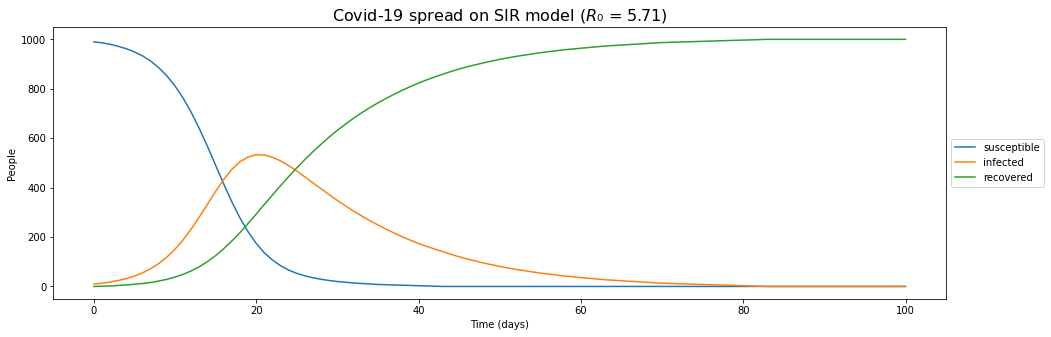

In [5]:
sir = experiments[simulation == 0]
plt.rcParams["figure.figsize"]=20,5
fig, ax = plt.subplots()
ax.plot(sir['timestep'], sir['susceptible'], label='susceptible')
ax.plot(sir['timestep'], sir['infected'], label='infected')
ax.plot(sir['timestep'], sir['recovered'], label='recovered')
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])

# Put a title on the plot
plt.title("Covid-19 spread on SIR model ($R₀$ = 5.71)", fontsize=16)

# Put a legend to the right of the current axis
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax.set_xlabel("Time (days)")
ax.set_ylabel("People")
plt.show()

# Covid-19 SEIR model

The SIR model can give us a decent analysis on the behavior of an infectious disease, but its simplicity limitates it. As many infections, Covid-19 has a significant incubation period during which individuals have been infected but neither show symptoms nor are capable of infecting other individuals. Because of that, the **SEIR** model can represent it in a better way.


The SEIR model is described by the following equations:

\begin{aligned}{\frac {d}{dt}Susceptible}&= - \beta * Infected * {\frac {Susceptible}{Total Population}}
\\{\frac {d}{dt}Exposed}&=\beta * Infected * {\frac {Susceptible}{Total Population}} - \delta * Exposed 
\\{\frac{d}{dt}Infected}&=\delta * Exposed - \gamma * Infected
\\{\frac {d}{dt}Recovered}&=\gamma*Infected
\end{aligned}

Where the parameters are:
- **Infection rate** ($\beta$): expected amount of people an infected person infects per day
- **Recovering rate** ($\gamma$): the proportion of infected people recovering per day ($\gamma$ = 1 / recovery time in days)
- **Exposure rate** ($\delta$): expected rate that exposed people turn into infected ($\delta$ = 1 / incubation period in days)

As seen above, SEIR also considers the disease's death rate negligible. It's also notable that it has very similar equations to SIR. Besides adding an equation that represents the exposed population, SEIR also has differences in the infected population equation.

While SIR considered the difference between **the amount of individuals infected by and infected person** and the amount of infected individuals recovering per day, SEIR considers the difference between **the amount of exposed individuals turned into infected** and the amount of infected individuals recovering per day.

When conceptually analyzing the meaning of each compartment, it becomes very simple to understand this change in the equation.


## Covid-19 SEIR model stock and flow diagram 

Differently from SIR model, the population in SEIR doesn't flow directly from the susceptible stock to the infected one. Firstly, the exposed growth makes them flow to the exposed stock; after the incubation period, the infected growth makes them flow to the infected stock and, after the recovery time, the population finally flows to the recovered stock.



![covid-19 SEIR model mechanism](images/covid-19_seir_model_stock_flow.png)

## Covid-19 SEIR model mechanism

As seen in the equations and the stock and flow diagram, the difference between both models' mechanisms is that SEIR has an exposed growth behavior that triggers a decrease in the susceptible population and an increase in the exposed population. Besides that, infected growth causes a decrease in the exposed population, differently from SIR, where it decreased the susceptible one. Exogenous processes still weren't added to the model.

![covid-19 SIR model mechanism](images/covid-19_seir_model.png)

## Simulation results

The model's simulation was created given the following parameters and initial state variables:
- **Infection rate** ( $\beta$ ): 1 (this means an infected individual infects another individual once a day);
- **Recovering rate** ( $\gamma$ ): 0.25 (differently from SIR model, this parameter is calculated using an average recovery time of 4 days. So, $\gamma$ = 1 / 4 = 0.25);
- **Reproductive number** ($R₀$): $\beta$ / $\gamma$ = 4; 
- **Exposure rate** ($\delta$): 0.333 (as $\delta$ = 1 / incubation period in days, this parameter is calculated using an average incubation period of 3 days. So, $\delta$ = 1 / 3 $\approx$ 0.333;
- **Susceptible population**: 990;
- **Exposed population**: 10;
- **Infected population**: 0;
- **Recovered population**: 0.

As we can see, the parameters are very different from the ones used in SIR's simulation. This was made in order to see the difference this parameters make on the system's behavior. As said in the beginning of the notebook, the differential of using cadCAD is the ability to create varied scenarios of a system.

The graph shows some notable differences from the one shown in SIR model:
- The susceptible population decreases at low rate for slightly longer than on SIR, beginnig to decrease considerably around the 15th day;
- The exposed population reaches higher increase rates approximately at the same time that susceptible population begins to decrease, but because of the high $\delta$ used, the curve is quite flat;
- The infected population shows a very similar behavior to exposed one, with a little "delay" (justified by the incubation period) and a higher peak (justified by the lower recovering rate than the exposure rate). It is also much flatter than the presented on SIR, which shows the influence of $R₀$ on the system's behavior;
- The recovered population reaches its peak considerably before than on SIR, with a much higher growth rate between timesteps 15 and 30.

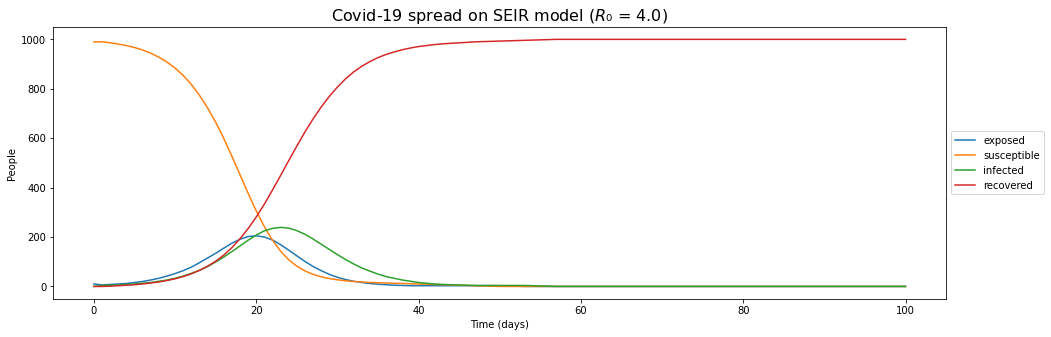

In [6]:
seir = experiments[simulation == 1]
fig, ax = plt.subplots()
plt.rcParams["figure.figsize"]=20,5
ax.plot(seir['timestep'], seir['exposed'], label='exposed')
ax.plot(seir['timestep'], seir['susceptible'], label='susceptible')
ax.plot(seir['timestep'], seir['infected'], label='infected'   )
ax.plot(seir['timestep'], seir['recovered'], label='recovered')
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])

# Put a title on the plot
plt.title("Covid-19 spread on SEIR model ($R₀$ = 4.0)", fontsize=16)

# Put a legend to the right of the current axis
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

ax.set_xlabel("Time (days)")
ax.set_ylabel("People")
plt.show()

# Covid-19 SEIRD model

As we know, Covid-19 is a disease with a significant death rate (around 5% worldwide). Because of that, SIR and SEIR models can be considerably inaccurate. Therefore, the SEIRD model can better represent Covid-19, as it includes individuals who died because of the disease in compartment **D**.

The SEIRD model is based on the following equations:

\begin{aligned}{\frac {d}{dt}Susceptible}&= - \beta * Infected * {\frac {Susceptible}{Total Population}}
\\{\frac {d}{dt}Exposed}&=\beta * Infected * {\frac {Susceptible}{Total Population}} - \delta * Exposed 
\\{\frac{d}{dt}Infected}&=\delta * Exposed - (1 - \alpha) * \gamma * Infected - \alpha * \rho * Infected
\\{\frac {d}{dt}Recovered}&= (1 - \alpha) * \gamma *Infected
\\{\frac {d}{dt}Dead}&=\alpha * \rho * Infected\end{aligned}

Where the parameters are:
- **Infection rate** ($\beta$): expected amount of people an infected person infects per day
- **Recovering rate** ($\gamma$): the proportion of infected people recovering per day ($\gamma$ = 1 / recovery time in days)
- **Exposure rate** ($\delta$): expected rate that exposed people turn into infected ($\delta$ = 1 / incubation period in days)
- **Death proportion rate** ($\rho$): rate at which infected people die per day ($\rho$ = 1 / days from infection until death)
- **Death rate** ($\alpha$): the probability an infected person has of dying

We can again see that the equations are similar to the previous models. Besides including a death population equation, the differences occur in the infected and recovered ones, where **death rate is now considered**.

## Covid-19 SEIRD model stock and flow diagram 

The stock and flow diagram shows that, in SEIRD model, the population in the infected stock can flow to two population stocks (dead or recovered).

![covid-19 SEIRD model mechanism](images/covid-19_seird_model_stock_flow.png)

## Covid-19 SEIRD model mechanism 

The difference between SEIR and SEIRD mechanisms is simply the addition of a death growth behavior that increases the dead population and decreases the infected population. It's interesting to observe that on SEIRD, we have a mechanism (infected population) that is triggered by three different behaviors, which shows cadCAD'S potential of adding complexity to a system.

![covid-19 SEIRD model mechanism](images/covid-19_seird_model.png)

## Simulation results

We will introduce parameter sweeping in SEIRD model. This feature will alow us to analyze two scenarios of Covid-19's spread based on two different reproductive numbers. As the recovering rate is a disease characteristic, it tends to remain constant, while the infection rate is a characteristic that depends on several factors other than the disease itself (e.g. social isolation policies). Because of that, in order to get different values for $R₀$, we have to work with different values for $\beta$.

The first model's simulation was created given the following parameters and initial state variables:
- **Infection rate** ( $\beta$ ): 0.4;
- **Recovering rate** ( $\gamma$ ): 0.25;
- **Reproductive number** ($R₀$): $\beta$ / $\gamma$ = 1.6; 
- **Exposure rate** ($\delta$): 0.333;
- **Death proportion rate** ($\rho$): 0.111 (as $\rho$ = 1 / days from infection until death, this means the average time from infection until death is 9 days);
- **Death rate** ($\alpha$): 0.01 (this means 1% of infected people will die);
- **Susceptible population**: 9990;
- **Exposed population**: 100;
- **Infected population**: 0;
- **Recovered population**: 0;
- **Dead population**: 0.

When comparing it to SEIR's simulation, we can observe that the change in the reproductive number drastically changes the population curves. The exposed and infected populations took much longer to grow and were much flatter. Similarly, susceptible and recovered populations also took longer to respectively decrease and increase.

Although we aren't considering the death rate as negligible anymore, the dead population grew very little in the first 100 days, which makes sense when we look at the $\rho$ and $\alpha$ values used, which are considerably low.

It's also notable that, differently from the other simulations did before, at the end of the first 100 days there are people who didn't even got exposed or infected, making both susceptible and recovered populations to be different from zero (in the other simulations, the entire population was recovered after the first 100 days).

However, this simulation doesn't represent the Covid-19 spread accurately, because as said before, its $R₀$ is usually much higher than 1.6. This simulation may represent the spread of **common flu** considerably well, as its mean $R₀$ is around 1.3 [[4]](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC2715422/).

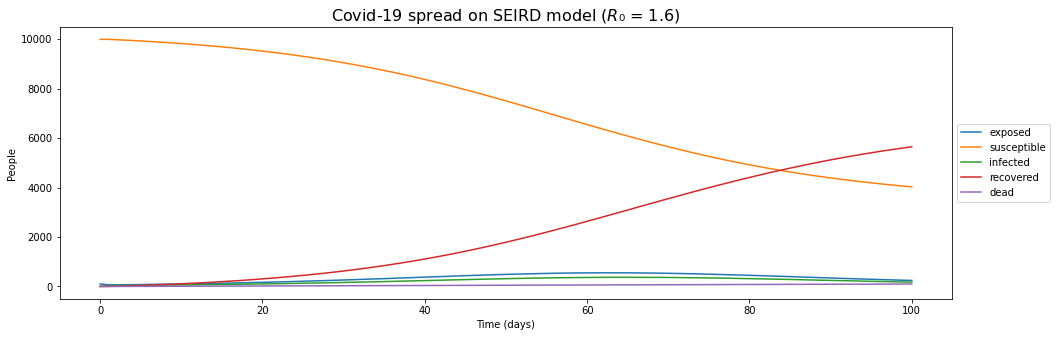

In [7]:
seird_1 = experiments[(simulation == 2) & (subset == 0)]
fig, ax = plt.subplots()
plt.rcParams["figure.figsize"]=20,5
ax.plot(seird_1['timestep'], seird_1['exposed'], label='exposed')
ax.plot(seird_1['timestep'], seird_1['susceptible'], label='susceptible')
ax.plot(seird_1['timestep'], seird_1['infected'], label='infected'   )
ax.plot(seird_1['timestep'], seird_1['recovered'], label='recovered')
ax.plot(seird_1['timestep'], seird_1['dead'], label='dead')
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])

# Put a title on the plot
plt.title("Covid-19 spread on SEIRD model ($R₀$ = 1.6)", fontsize=16)

# Put a legend to the right of the current axis
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

ax.set_xlabel("Time (days)")
ax.set_ylabel("People")
plt.show()

For the second SEIRD simulation, the only parameter changed was the infection rate and, consequently, the reproductive number:
- **Infection rate** ($\beta$): 0.2 (this means an individual infects another individual every 5 days);
- **Reproductive number** ($R₀$): $\beta$ / $\gamma$ = 0.2/0.25 = 0.8.

This change allows us to clearly observe the relevance of $R₀$ in an infectious disease spread. When replacing the previously used value for its half, the populations change very little from their initial states. The infected population peak is so low that we can't even see it on the graph. Consequently, the massive majority of the population remains susceptible for the first 100 days and will propably continue as that since the infected population is negligible at that time.

This simulation also shows the importance of keeping a disease's $R₀$ lower than 1, as that is what makes it unable to spread in a population.

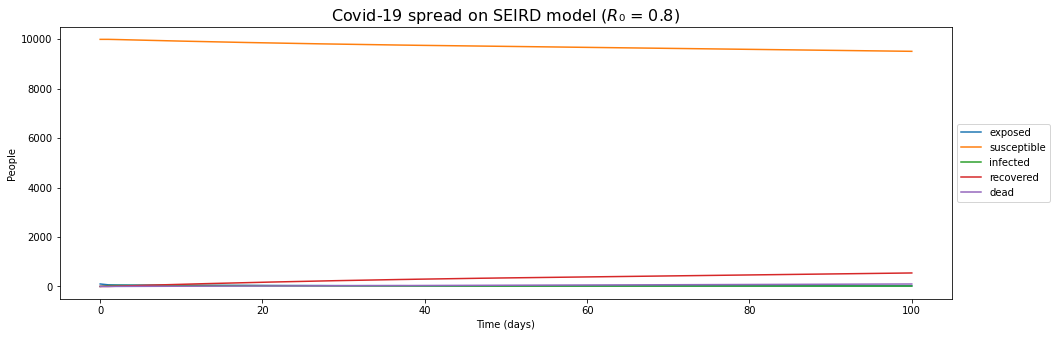

In [8]:
seird_2 = experiments[(simulation == 2) & (subset == 1)]
fig, ax = plt.subplots()
plt.rcParams["figure.figsize"]=20,5
ax.plot(seird_2['timestep'], seird_2['exposed'], label='exposed')
ax.plot(seird_2['timestep'], seird_2['susceptible'], label='susceptible')
ax.plot(seird_2['timestep'], seird_2['infected'], label='infected'   )
ax.plot(seird_2['timestep'], seird_2['recovered'], label='recovered')
ax.plot(seird_2['timestep'], seird_2['dead'], label='dead')
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])

# Put a title on the plot
plt.title("Covid-19 spread on SEIRD model ($R₀$ = 0.8)", fontsize=16)

# Put a legend to the right of the current axis
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

# Put labels on axis
ax.set_xlabel("Time (days)")
ax.set_ylabel("People")
plt.show()

# Covid-19 SEIR model with stochastic parameters (SEIRBayes)



Now that we explored the dynamics of an epidemic, we can try to get our model closer to how real world works. For this, as said before, we will add stochasticity to its parameters. The method chosen to do this is **Bayesian inference**. As explained in Wikipedia, 

> "Bayesian inference is a method of statistical inference in which Bayes' theorem is used to update the probability for a hypothesis as more evidence or information becomes available. Bayesian inference is an important technique in statistics, and especially in mathematical statistics. Bayesian updating is particularly important in the dynamic analysis of a sequence of data."

You can read more about Bayesian inference on Wikipedia's page: https://en.wikipedia.org/wiki/Bayesian_inference.

In our system's case, the epidemiological parameters become variables that have a probability of assuming certain values, while the probability distribution (i.e., **the function that gives the probability of each value's occurrence**) varies as the model evolves.

Thus, the outcomes of our system won't be curves that assume a specific value at each timestep anymore; instead, they will be curves with **a range of possible values over time**. This can be done quite easily on cadCAD with **Monte Carlo Method**.

At each Monte Carlo run, the epidemiological parameters will change with a different random seed informed in the script. This will allow us to have **a stochastic model while keeping it reproducible**.

In order to get a plot that shows the probability distribution of each population over time, we will need to do some data processing. The functions `take_max()`, `take_min()` and `take_mean` are used, respectively, to get the maximum, minimum and mean values of each state variable over time. Afterwards, `stochastic_plot()` plots the mean lines and shows the range of each population over time.

In [9]:
def clean_df(df):
    df.reset_index(inplace=True)
    df.drop(['index'], axis=1, inplace=True)

def take_max(df):
    max_ = list()
    for row in df:
        max_.append(row.max())
    return max_

def take_min(df):
    min_ = list()
    for row in df:
        min_.append(row.min())
    return min_

def take_mean(df):
    mean_ = list()
    for row in df:
        mean_.append(row.sum()/len(row))
    return mean_

def stochastic_plot(dfs):
    susceptible = []
    exposed = []
    infected = []
    recovered = []
    for df in dfs:
        clean_df(df)
        susceptible.append(df['susceptible'].values)
        exposed.append(df['exposed'].values)
        infected.append(df['infected'].values)
        recovered.append(df['recovered'].values)

    susceptible = np.transpose(susceptible)
    exposed = np.transpose(exposed)
    infected = np.transpose(infected)
    recovered = np.transpose(recovered)

    raw_data = {'susceptible': list(susceptible[:]), 
                'exposed': list(exposed[:]),
                'infected': list(infected[:]),
                'recovered': list(recovered[:])
               }
    result = pd.DataFrame(raw_data, 
                          columns=['susceptible', 
                                   'exposed', 
                                   'infected', 
                                   'recovered'])
    result['timestep'] = dfs[0]['timestep']

    plt.rcParams["figure.figsize"]=20,5

    fig, ax = plt.subplots()

    ax.plot(result['timestep'], take_mean(result['susceptible']), label='susceptible')
    ax.fill_between(result['timestep'],
                    take_min(result['susceptible']), 
                    take_max(result['susceptible']), alpha=0.2)

    ax.plot(result['timestep'], take_mean(result['exposed']), label='exposed')
    ax.fill_between(result['timestep'],
                    take_min(result['exposed']), 
                    take_max(result['exposed']), alpha=0.2)

    ax.plot(result['timestep'], take_mean(result['infected']), label='infected')
    ax.fill_between(result['timestep'],
                    take_min(result['infected']), 
                    take_max(result['infected']), alpha=0.2)

    ax.plot(result['timestep'], take_mean(result['recovered']), label='recovered')
    ax.fill_between(result['timestep'],
                    take_min(result['recovered']), 
                    take_max(result['recovered']), alpha=0.2)

    box = ax.get_position()
    ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
    ax.ticklabel_format(style='plain')

    # Put a legend to the right of the current axis
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    ax.set_xlabel("Time (days)")
    ax.set_ylabel("People")
    plt.show()

## Simulation results

As the model equations and mechanisms will remain the same as those of the deterministic SEIR model, we will move forward to its results. Since our parameters are now random variables, four inputs will be given to them in order to characterize their distribution: **lower bound**, **upper bound**, **probability density** and **distribution family**. The probability density used was the same for all variables (0.95), as well as the distribution family (log-normal distribution). For the first tests, we decided to run **2 simulations with 10 Monte Carlo runs each**. Besides that, **the recovering ($\gamma$) and exposure ($\delta$) rate parameters were replaced by the recovering and incubation periods**, which are simply their reciprocals. The bounds and initial state varbiables of the first simulation are listed below:

- **Infectious period ($\gamma$)**: Lower bound: 7.0; upper bound: 14.0;
- **Incubation period ($\delta$)**: Lower bound: 4.1; upper bound: 7.0;
- **Reproductive number ($R₀$)**: Lower bound: 2.5; upper bound: 4;
- **Susceptible population**: 999990;
- **Exposed population**: 10;
- **Infected population**: 10;
- **Recovered population**: 0;

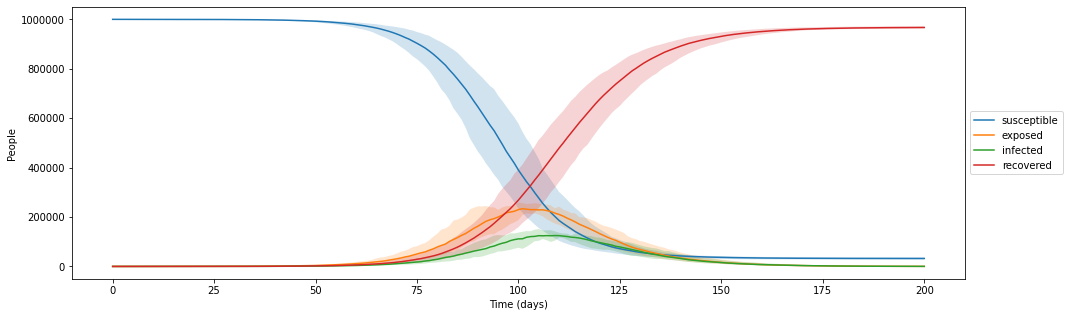

In [10]:
from covid_19_stochastic.config import MONTE_CARLO_RUNS

dataframe = experiments[simulation == 3]
dfs = np.array_split(dataframe, MONTE_CARLO_RUNS)
stochastic_plot(dfs)

The only change made for the second simulation was in $R₀$'s bounds. As $\alpha$ and $\gamma$ are more stable parameters (they are different from one disease to another, but usually vary little for the same disease in different scenarios), keeping them at the same values makes sense, since our main objective is to analyze how political and geographical may affect Covid-19's spread.

The bounds of the second simulation are listed below:

- **Infectious period ($\gamma$)**: Lower bound: 7.0; upper bound: 14.0;
- **Incubation period ($\delta$)**: Lower bound: 4.1; upper bound: 7.0;
- **Reproductive number ($R₀$)**: Lower bound: 4; upper bound: 6;
- **Susceptible population**: 999990;
- **Exposed population**: 10;
- **Infected population**: 10;
- **Recovered population**: 0.

By analyzing both simulations, we can clearly see that the different probability distribution affected not only the population means over time, but also their amplitude, since the chosen intervals for $R₀$ on the second simulation had a lower amplitude than on the first.

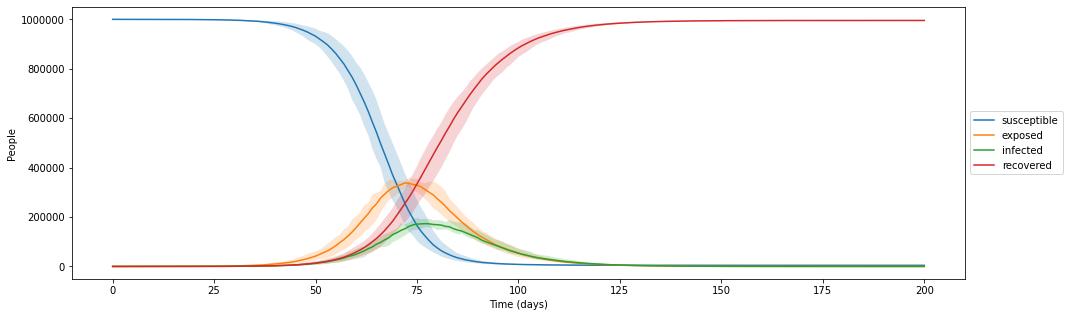

In [11]:
dataframe = experiments[simulation == 4]
dfs = np.array_split(dataframe, MONTE_CARLO_RUNS)
stochastic_plot(dfs)